# Advanced Econometrics (JEM217)– Home Assignment 1 (WS 2025)



**AI Usage**

ChatGPT-5 was used during the preparation of this assignment **solely for grammatical editing and minor code optimization**.  
Any sections where AI-assisted code optimization was applied are explicitly indicated within the notebook.

## Initial Preparation

In this section, we install and load all required R packages necessary for data simulation, estimation, and visualization.  
We also set a fixed random seed (`set.seed(123)`) to ensure that all simulated results are fully reproducible.


In [6]:

req_pkgs <- c("ggplot2","dplyr","quantreg","lmtest","sandwich","car","stargazer","knitr","glm2")
for (p in req_pkgs) {
  if (!requireNamespace(p, quietly = TRUE)) {
    install.packages(p, repos = "https://cloud.r-project.org")
  }
}
library(ggplot2)
library(dplyr)
library(quantreg)
library(lmtest)
library(sandwich)
library(car)
library(stargazer)
library(knitr)
library(glm2)

set.seed(123) 


Installing package into 'C:/Users/fazol/AppData/Local/R/win-library/4.4'
(as 'lib' is unspecified)



package 'glm2' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\fazol\AppData\Local\Temp\Rtmpori02v\downloaded_packages


Warning message:
"package 'dplyr' was built under R version 4.4.3"

Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"package 'quantreg' was built under R version 4.4.3"
Loading required package: SparseM

Warning message:
"package 'SparseM' was built under R version 4.4.3"
Warning message:
"package 'lmtest' was built under R version 4.4.3"
Loading required package: zoo

Warning message:
"package 'zoo' was built under R version 4.4.3"

Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Warning message:
"package 'sandwich' was built under R version 4.4.3"
Warning message:
"package 'car' was built under R version 4.4.3"
Loading required package: carData

Warning message:
"package 'carData' was built under R version 4.4.3"

Attaching package: 'car'


The following

## Problem 1: Simulating Used Car Prices 
### 1) Data Simulation

We simulated according to the data‑generating process described in the assignment:
$
\text{price}_i = 1000 - 0.0005\,\text{milage}_i^2 - 5\,\text{years\_old}_i + 50\,\text{convertible}_i + 100\,\text{luxury}_i + \varepsilon_i,\quad \varepsilon_i\sim\mathcal{N}(0,15).
$

We also build a `data.frame` called `cars`.

We chose relatively small sample size 200 to obtain "interesting results" as was mentioned in the assignment.

In [ ]:

N <- 200

# Explanatory variables (X)
milage      <- rnorm(N, mean = 1000, sd = 300)
years_old   <- sample(2:15, N, replace = TRUE)
convertible <- rbinom(N, 1, 0.3)
luxury      <- rbinom(N, 1, 0.2)

# Error term
epsilon <- rnorm(N, mean = 0, sd = 15)

# Outcome
price <- 1000 - 0.0005 * milage^2 - 5 * years_old + 50 * convertible + 100 * luxury + epsilon

cars <- data.frame(price, milage, years_old, convertible, luxury)

# Peek
head(cars)


,price,milage,years_old,convertible,luxury
,<dbl>,<dbl>,<int>,<int>,<int>
1,652.9847,831.8573,8,1,0
2,594.6920,930.9468,4,1,0
3,-122.2930,1467.6125,10,0,0
4,443.0286,1021.1525,14,1,0
5,417.6969,1038.7863,8,0,0
6,-207.3756,1514.5195,15,0,0


### 1a) Descriptive Statistics & Figures

We report summary statistics, a scatterplot matrix, and selected plots. The values are expected.


     price            milage         years_old      convertible  
 Min.   :-987.8   Min.   : 307.2   Min.   : 2.00   Min.   :0.00  
 1st Qu.: 295.6   1st Qu.: 812.3   1st Qu.: 5.00   1st Qu.:0.00  
 Median : 476.1   Median : 982.4   Median : 9.00   Median :0.00  
 Mean   : 449.8   Mean   : 997.4   Mean   : 8.64   Mean   :0.29  
 3rd Qu.: 663.6   3rd Qu.:1170.5   3rd Qu.:12.00   3rd Qu.:1.00  
 Max.   :1022.9   Max.   :1972.3   Max.   :15.00   Max.   :1.00  
     luxury    
 Min.   :0.00  
 1st Qu.:0.00  
 Median :0.00  
 Mean   :0.17  
 3rd Qu.:0.00  
 Max.   :1.00  

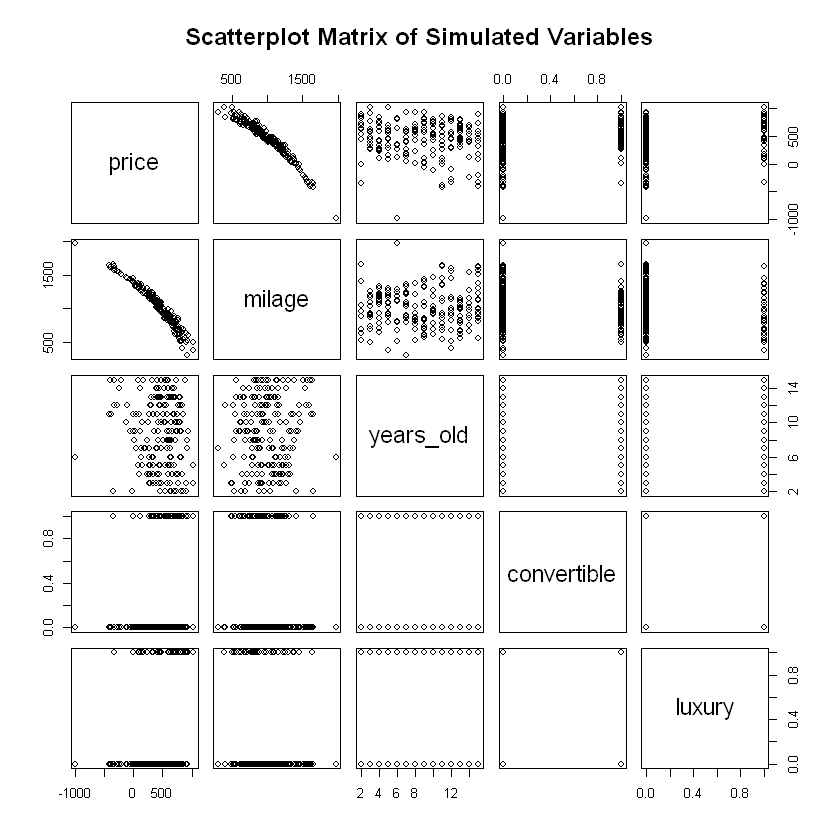

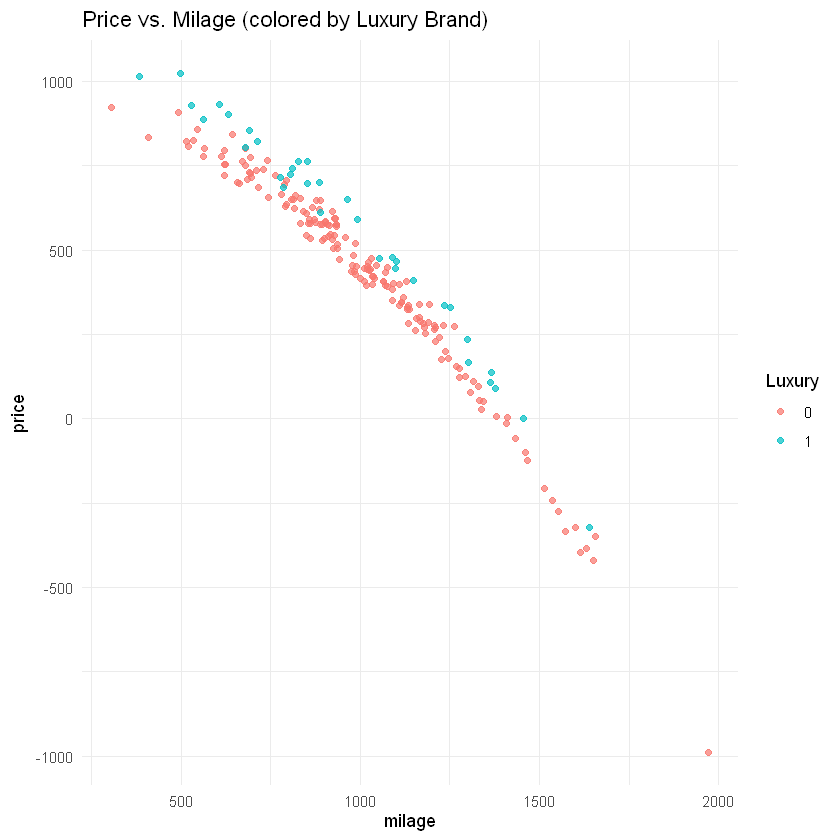

In [ ]:
# Summary statistics
summary(cars)

# A scatterplot matrix of all variables
pairs(cars, main = "Scatterplot Matrix of Simulated Variables")

# Price vs Milage colored by luxury brand
ggplot(cars, aes(x = milage, y = price, color = factor(luxury))) +
  geom_point(alpha = 0.7) +
  labs(title = "Price vs. Milage (colored by Luxury Brand)",
       color = "Luxury") +
  theme_minimal()





### 2) Misspecified Linear Model

We (incorrectly) omit the $\text{milage}^2$ term and include only a linear effect of milage:
$
\text{price}_i = \alpha_0 + \alpha_1\,\text{milage}_i + \alpha_2\,\text{years\_old}_i + \alpha_3\,\text{convertible}_i + \alpha_4\,\text{luxury}_i + u_i.
$

This induces functional form misspecification $\Rightarrow$ biased estimates. Specifically estimates of milage (-1.05) appear very different compared to the true parameter (-0.0005). This is caused by the efect of the linear parameter which is trying to "soak up" the true effect that is non-linear. Intercept is also biased (roughly 500 higher), it is also caused by the functional form misspecification. 

Since the other variables are generater without correlation to milage they are exogenous. This can be proven mathematically, since $\text{Bias}(\beta_j) = \gamma \cdot \pi_j$, where $\gamma$ is the effect of ommited variable (in this case $\text{milage}^2$), $j$ is the index of the other variables and $\pi_j$ is the slope from regressing the omitted variable on regressor $j$. We know that $\pi_j = 0$ and thus bias is zero $\Rightarrow$ those estimates are unbiased and consistent. We can see this visually since those estimates are very close to true value. The difference is caused by small sample size. 

To test this we can first check correlation between regressors and the omited variable. If the correlation is zero as sample size grows this indicates unbiased results. Moreover we did Ramsey Reset test to check functional form misspecification and the small p-value below indicates we can reject $H_0$: Correctly Specified with high confidence (more than 99\%)

In [17]:
model_wrong <- lm(price ~ milage + years_old + convertible + luxury, data = cars)
summary(model_wrong)

cor(cars$milage, cars$milage^2)      
cor(cars$years_old, cars$milage^2)   
cor(cars$convertible, cars$milage^2) 
cor(cars$luxury, cars$milage^2)
resettest(model_wrong, power = 2:3)


Call:
lm(formula = price ~ milage + years_old + convertible + luxury, 
    data = cars)

Residuals:
    Min      1Q  Median      3Q     Max 
-400.48  -14.46   15.99   35.48   73.31 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) 1509.35641   18.22953  82.797  < 2e-16 ***
milage        -1.04522    0.01507 -69.342  < 2e-16 ***
years_old     -5.86401    1.04802  -5.595 7.38e-08 ***
convertible   61.21950    9.34337   6.552 4.93e-10 ***
luxury        93.42512   11.26295   8.295 1.76e-14 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 59.43 on 195 degrees of freedom
Multiple R-squared:  0.9646,	Adjusted R-squared:  0.9638 
F-statistic:  1327 on 4 and 195 DF,  p-value: < 2.2e-16


[1] 0.9819379

[1] 0.07004344

[1] -0.1413081

[1] -0.04953402


	RESET test

data:  model_wrong
RESET = 716.76, df1 = 2, df2 = 193, p-value < 2.2e-16


### 3) Correct Functional Specification

Now we estimated the true functional form with $\text{milage}^2$:
$
\text{price}_i = \alpha_0 + \beta_1\,\text{milage}_i^2 + \beta_2\,\text{years\_old}_i + \beta_3\,\text{convertible}_i + \beta_4\,\text{luxury}_i + \varepsilon_i.
$

We also test whether the estimated coefficients equal the true values via Wald tests: $1000, -0.0005, -5, 50, 100$. The Wald test has p-value of 31.5\%. This implies that we cannot reject null hypothesis with any meaningful confidence (for example $> 90\%$), and thus we cannot say that those estimates **are not** equal to the true values.

**We did use AI** when conducting the wald test in order to obtain optimal code

In [16]:
model_true <- lm(price ~ I(milage^2) + years_old + convertible + luxury, data = cars)
summary(model_true)

# Wald tests for equality to true parameters
lh_res <- car::linearHypothesis(
  model_true,
  c("(Intercept) = 1000",
    "I(milage^2) = -0.0005",
    "years_old = -5",
    "convertible = 50",
    "luxury = 100")
)
lh_res




Call:
lm(formula = price ~ I(milage^2) + years_old + convertible + 
    luxury, data = cars)

Residuals:
    Min      1Q  Median      3Q     Max 
-41.625  -9.810   0.211   9.937  39.366 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.002e+03  3.180e+00  315.03   <2e-16 ***
I(milage^2) -5.002e-04  1.752e-06 -285.54   <2e-16 ***
years_old   -5.373e+00  2.594e-01  -20.71   <2e-16 ***
convertible  4.909e+01  2.317e+00   21.19   <2e-16 ***
luxury       1.045e+02  2.784e+00   37.53   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 14.7 on 195 degrees of freedom
Multiple R-squared:  0.9978,	Adjusted R-squared:  0.9978 
F-statistic: 2.243e+04 on 4 and 195 DF,  p-value: < 2.2e-16


,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,200,43443.49,NA,NA,NA,NA
2,195,42157.81,5,1285.688,1.189384,0.3157863


### 4) Heteroskedasticity Scenario and Corrections

We now simulated a new outcome where the error term is proportional to milage:
$
\text{price}_i = 1000 - 0.0005\,\text{milage}_i^2 - 5\,\text{years\_old}_i + 50\,\text{convertible}_i + 100\,\text{luxury}_i + \text{milage}_i\ \cdot \varepsilon_i.
$



Since the multiplicative heteroskedasticity is proportional to mileage. OLS coefficients remain unbiased and consistent (exogeneity holds), but usual OLS standard errors are invalid and efficiency is lost. The B-P test has very low p-value thus we reject null hypothesis of homoskedasticity. With use of robust (HC1) SEs we fixed the inference with misspecified variance. Next we divided the whole model with $\frac{1}{\text{milage}}$, which is the true form of heteroskedasticity further improving SEs, but in proces we changed the interpetation of the intercept which is now $\frac{\text{intercept}}{\text{milage}}$, similarly ve divided all other variables including $y$ and we now only have linear effect of milage, thus our interpretation changes.

In [ ]:
# Multiplicative heteroskedasticity
epsilon2 <- rnorm(N, 0, 15)
price2 <- 1000 - 0.0005 * milage^2 - 5 * years_old + 50 * convertible + 100 * luxury + milage * epsilon2

cars2 <- data.frame(price2, milage, years_old, convertible, luxury)

# "True" structural regressors 
model_het <- lm(price2 ~ I(milage^2) + years_old + convertible + luxury, data = cars2)
summary(model_het)

# Breusch-Pagan test for heteroskedasticity
bp <- bptest(model_het)
bp

# Robust standard errors
robust_vcov <- vcovHC(model_het, type = "HC1")
robust_se <- sqrt(diag(robust_vcov))

# Coefficients with robust SEs
lmtest::coeftest(model_het, vcov = robust_vcov)

# Known-form correction: dividing both sides by milage
cars2 <- cars2 %>% mutate(
  price2_adj   = price2 / milage,
  milage2_adj  = (milage^2) / milage,   
  years_adj    = years_old / milage
)

model_corrected <- lm(price2_adj ~ milage2_adj + years_adj + convertible + luxury, data = cars2)
summary(model_corrected)




Call:
lm(formula = price2 ~ I(milage^2) + years_old + convertible + 
    luxury, data = cars2)

Residuals:
   Min     1Q Median     3Q    Max 
-58767  -7744    623   9595  59555 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)  
(Intercept)  5.359e+03  3.348e+03   1.601   0.1110  
I(milage^2)  2.569e-04  1.844e-03   0.139   0.8893  
years_old   -5.964e+02  2.731e+02  -2.184   0.0302 *
convertible  1.836e+03  2.439e+03   0.753   0.4525  
luxury      -1.244e+03  2.931e+03  -0.425   0.6716  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 15480 on 195 degrees of freedom
Multiple R-squared:  0.02921,	Adjusted R-squared:  0.009297 
F-statistic: 1.467 on 4 and 195 DF,  p-value: 0.2138



	studentized Breusch-Pagan test

data:  model_het
BP = 37.088, df = 4, p-value = 1.728e-07



t test of coefficients:

               Estimate  Std. Error t value Pr(>|t|)  
(Intercept)  5.3593e+03  3.8160e+03  1.4044  0.16178  
I(milage^2)  2.5692e-04  2.9130e-03  0.0882  0.92981  
years_old   -5.9641e+02  2.7156e+02 -2.1963  0.02925 *
convertible  1.8359e+03  2.1942e+03  0.8367  0.40376  
luxury      -1.2442e+03  3.4768e+03 -0.3579  0.72083  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



Call:
lm(formula = price2_adj ~ milage2_adj + years_adj + convertible + 
    luxury, data = cars2)

Residuals:
    Min      1Q  Median      3Q     Max 
-43.457  -8.863  -0.087   9.836  38.537 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)  
(Intercept)  1.178e+01  5.745e+00   2.051   0.0416 *
milage2_adj -6.954e-03  4.199e-03  -1.656   0.0993 .
years_adj   -4.099e+02  2.202e+02  -1.861   0.0642 .
convertible  9.042e-01  2.280e+00   0.397   0.6921  
luxury      -1.120e+00  2.738e+00  -0.409   0.6828  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 14.47 on 195 degrees of freedom
Multiple R-squared:  0.02431,	Adjusted R-squared:  0.004293 
F-statistic: 1.215 on 4 and 195 DF,  p-value: 0.3059


### 5) Quantile Regression (τ = 0.05 to 0.95 by 0.05)

We estimated quantile regressions for the correctly specified model and plot how key coefficients vary across quantiles. This reveals distributional heterogeneity beyond the conditional mean. We can see that the estimates of different quantiles vary, for example for $\text{milage}^2$ variable, but those difference are rather small and insignificant. Nevertheless quantile regression did uncover more precise estimates of different part of the population, but again in this case not so significant differences.

,(Intercept),I(milage^2),years_old,convertible,luxury,tau
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,977.5517,-0.0005007882,-4.893971,45.13564,90.68729,0.05
2,979.2472,-0.0004983454,-5.138985,48.22828,108.28120,0.10
3,985.9332,-0.0004989380,-5.478099,50.12994,107.91111,0.15
4,986.8641,-0.0004993317,-5.378036,52.00613,106.61015,0.20
5,992.3923,-0.0005007132,-5.407758,49.08453,107.27943,0.25
6,995.8403,-0.0005014957,-5.471076,49.14202,105.99357,0.30


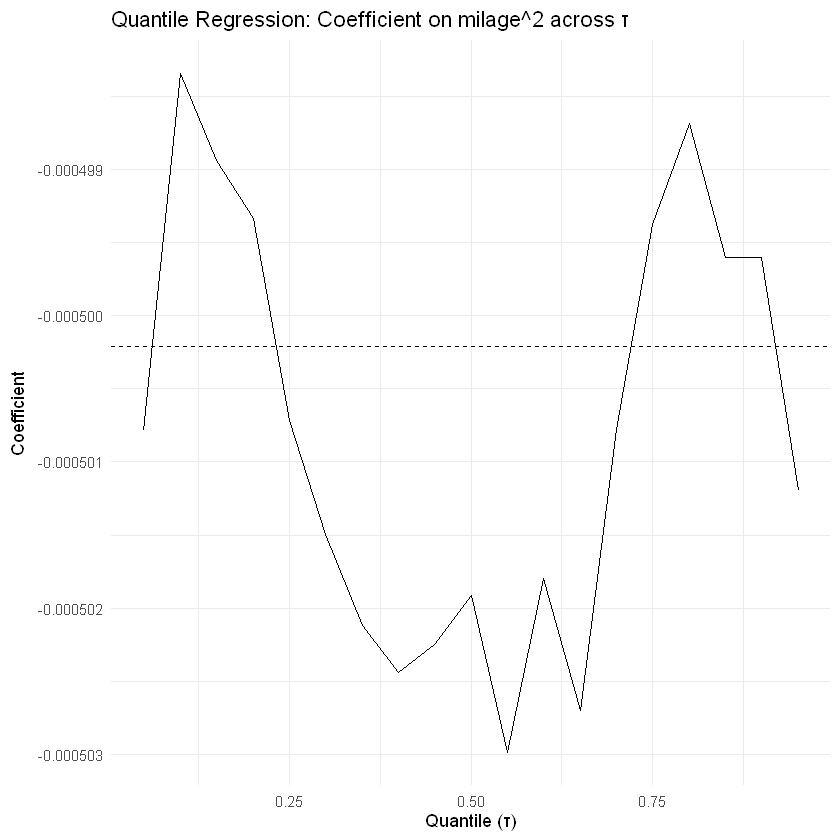

In [ ]:
taus <- seq(0.05, 0.95, by = 0.05)
qr_models <- lapply(taus, function(tau) {
  quantreg::rq(price ~ I(milage^2) + years_old + convertible + luxury, data = cars, tau = tau)
})

# Coefficients
coef_mat <- sapply(qr_models, coef)
coef_df <- as.data.frame(t(coef_mat))
coef_df$tau <- taus

head(coef_df)

# Plots
  ggplot(coef_df, aes(x = tau, y = `I(milage^2)`)) +
    geom_line() +
    geom_hline(yintercept = coef(model_true)["I(milage^2)"], linetype = "dashed") +
    labs(title = "Quantile Regression: Coefficient on milage^2 across τ",
        x = "Quantile (τ)", y = "Coefficient") +
    theme_minimal()




# Problem 2 — Vietnam Living Standards Survey (1997)
### Q1 — Data selection, summary, proportions, and basic graphs

'data.frame':	5999 obs. of  6 variables:
 $ lhhexp1 : num  10.1 10.3 10.9 10.3 10.5 ...
 $ lhhex12m: num  11.23 8.51 8.71 9.29 7.56 ...
 $ farm    : Factor w/ 2 levels "non farm","farm": 1 1 1 1 1 1 1 1 1 1 ...
 $ urban98 : Factor w/ 2 levels "Rural","Urban": 2 2 2 2 2 2 2 2 2 2 ...
 $ age     : int  68 57 42 72 73 66 73 46 50 45 ...
 $ sex     : int  2 2 1 2 2 2 2 1 1 1 ...
 - attr(*, "datalabel")= chr ""
 - attr(*, "time.stamp")= chr "19 Sep 2002 21:45"
 - attr(*, "formats")= chr [1:9] "%8.0g" "%8.0g" "%9.0g" "%9.0g" ...
 - attr(*, "types")= int [1:9] 98 105 102 102 98 108 102 102 102
 - attr(*, "val.labels")= chr [1:9] "" "" "" "loaiho" ...
 - attr(*, "var.labels")= chr [1:9] "Gender of HH.head (1:M;2:F)" "Age of household head" "schooling year of HH.head" "Type of HH (1:farm; 0:nonfarm)" ...
 - attr(*, "expansion.fields")=List of 3
  ..$ : chr [1:3] "_dta" "iis" "househol"
  ..$ : chr [1:3] "_dta" "strata" "commune"
  ..$ : chr [1:3] "_dta" "pweight" "wt"
 - attr(*, "version")= int

    lhhexp1          lhhex12m            farm       urban98          age       
 Min.   : 6.543   Min.   : 0.000   non farm:2561   Rural:4269   Min.   :16.00  
 1st Qu.: 8.920   1st Qu.: 5.273   farm    :3438   Urban:1730   1st Qu.:37.00  
 Median : 9.311   Median : 6.372                                Median :46.00  
 Mean   : 9.342   Mean   : 6.311                                Mean   :48.01  
 3rd Qu.: 9.759   3rd Qu.: 7.392                                3rd Qu.:58.00  
 Max.   :12.202   Max.   :12.363                                Max.   :95.00  
                  NA's   :993                                                  
      sex       
 Min.   :1.000  
 1st Qu.:1.000  
 Median :1.000  
 Mean   :1.271  
 3rd Qu.:2.000  
 Max.   :2.000  
                


        1         2 
0.7292882 0.2707118 


 non farm      farm 
0.4269045 0.5730955 


    Rural     Urban 
0.7116186 0.2883814 

,lhhexp1,lhhex12m,age
lhhexp1,1.00000000,0.2422273,-0.03740293
lhhex12m,0.24222730,1.0000000,0.11099332
age,-0.03740293,0.1109933,1.00000000


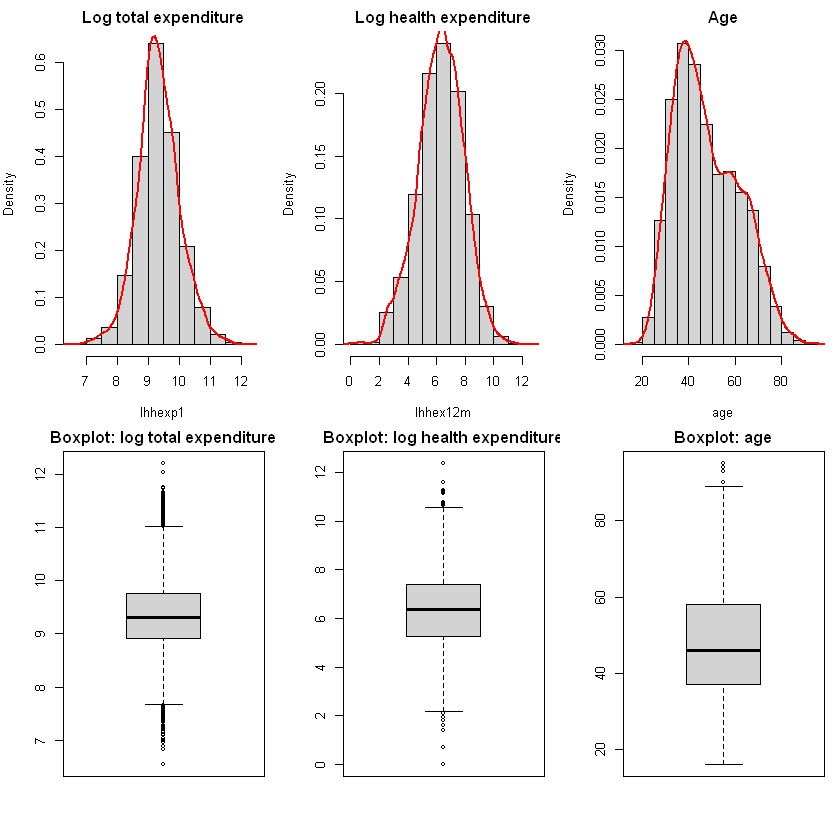

In [1]:
load("./problem_2_dataset.Rdata")
# variables 
q_data <- q_data |> dplyr::select(lhhexp1, lhhex12m, farm, urban98, age, sex)

# Structure and summary
str(q_data)
summary(q_data)

# Proportions for categorical variables
prop.table(table(q_data$sex))
prop.table(table(q_data$farm))
prop.table(table(q_data$urban98))

# Continuous variables: histograms with kernel density overlays
par(mfrow = c(2,3), mar = c(4,4,2,1))

hist(q_data$lhhexp1, probability = TRUE, main = "Log total expenditure",
     xlab = "lhhexp1", col = "lightgray")
lines(density(q_data$lhhexp1, na.rm = TRUE), col = "red", lwd = 2)

hist(q_data$lhhex12m, probability=TRUE, main="Log health expenditure",
     xlab="lhhex12m", col="lightgray")
lines(density(q_data$lhhex12m, na.rm=TRUE), col="red", lwd=2)

hist(q_data$age, probability=TRUE, main="Age", xlab="age", col="lightgray")
lines(density(q_data$age, na.rm=TRUE), col="red", lwd=2)

boxplot(q_data$lhhexp1, main = "Boxplot: log total expenditure")
boxplot(q_data$lhhex12m, main="Boxplot: log health expenditure")
boxplot(q_data$age, main="Boxplot: age")

par(mfrow = c(1,1))

# Simple correlation among continuous vars
cor(q_data[, c("lhhexp1", "lhhex12m", "age")], use="complete.obs")


 From the call of the function summary() most of the variables seem appropriate.
 From the categorical vars, we can see that much more observations come from the 
 rural part of the country and majority of them are men. 
 Th numerical vars, age includes people form 16 to 95 which possibly covers the whole range of
 feasible options. The expenditures on health includes almost a thousand NA´s which should be considered and 
 later potentially taken care of. The total expenditures takes on believable values. 
 With proportion tables we confirm that 73 % of the data set constitutes of men, 71 % come from 
 agricultural part of the country, the farm / non-farm are distributed almost evenly. 
 The histograms with included density lines and boxplots give us better information about the distribution
 of the cont vars. From the first type of graphs we can conclude that both of the expenditure vars  
 are approximately normally distributed and the age var is slightly skewed to the right. 
 The boxplots warn us about possible outliers problem especially for the total expenditure var.
 Lastly, we inspected if the correlation should concern us which turns out as it does not as the
 largest value is 24 %.

### Q2 — OLS model and interpretation

In [3]:
# Recode sex to factor with labels
q_data_adj <- q_data |>
  dplyr::mutate(sex = dplyr::case_when(
    sex == 1 ~ "male",
    sex == 2 ~ "female"
  )) |>
  dplyr::mutate(sex = factor(sex, levels = c("male","female")))

# OLS
model_1 <- lm(lhhex12m ~ lhhexp1 + farm + urban98 + age + sex, data = q_data_adj)
summary(model_1)


Call:
lm(formula = lhhex12m ~ lhhexp1 + farm + urban98 + age + sex, 
    data = q_data_adj)

Residuals:
    Min      1Q  Median      3Q     Max 
-6.5891 -0.9441  0.1066  1.0450  5.7723 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -1.033299   0.364076  -2.838 0.004556 ** 
lhhexp1       0.715841   0.036964  19.366  < 2e-16 ***
farmfarm      0.034002   0.055252   0.615 0.538312    
urban98Urban -0.385190   0.062356  -6.177 7.04e-10 ***
age           0.014186   0.001595   8.894  < 2e-16 ***
sexfemale     0.176317   0.051252   3.440 0.000586 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.526 on 5000 degrees of freedom
  (993 observations deleted due to missingness)
Multiple R-squared:  0.08373,	Adjusted R-squared:  0.08281 
F-statistic: 91.38 on 5 and 5000 DF,  p-value: < 2.2e-16


 The fitted linear model shows statistically significant positive effects of being a female compared to a man,
 age (where we could think if there is a quadratic relationship) and the total expenditures
 on health expenditures which also makes economical sense. The effect of a person 
 living in an urban area is negative and statistically significant which also seems logical because 
 goods and services are probably better accessible in a town than in a far village. The effect of 
 a person living on a farm proves statistically insignificant. According to the very low Adjusted R-squared 
 the model does not explain very much of the variation in the dependent variable 
 which might suggest that we are missing the important variables or even utilized
 not suitable estimating technique.

### Q3 — Quantile regression (τ = 0.05 … 0.95 by 0.10)


Warning message in summary.rq(xi, U = U, ...):
"7 non-positive fis"


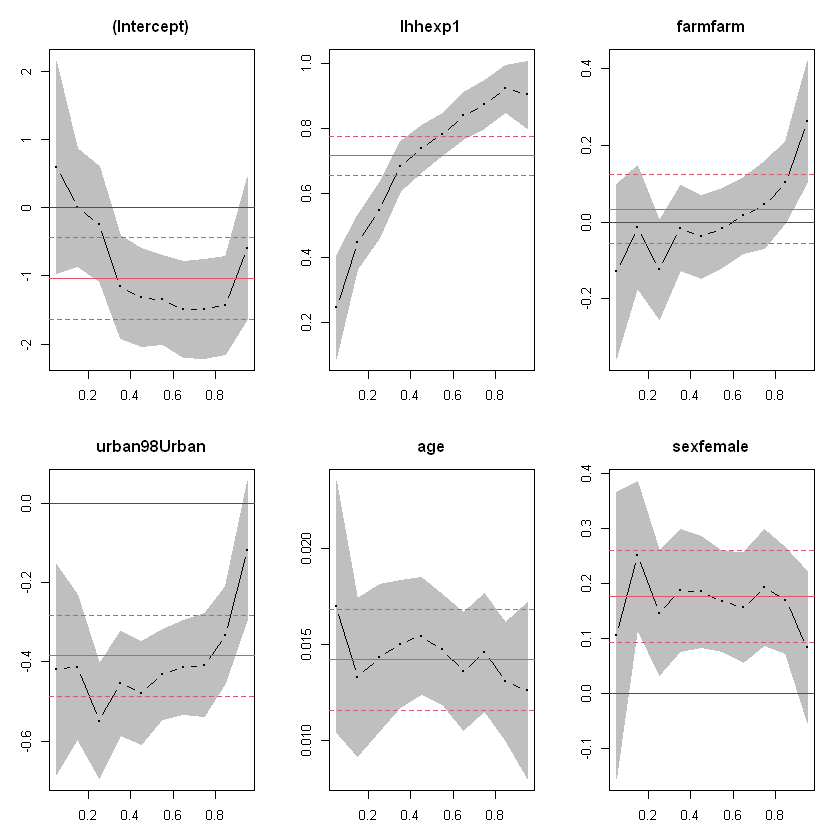

In [7]:
# quantile regressions across a grid of taus
taus <- seq(0.05, 0.95, by = 0.10)
qr_model_1 <- rq(lhhex12m ~ lhhexp1 + farm + urban98 + age + sex,
                 data = q_data_adj, tau = taus)
summary_qr_model_1 <- summary(qr_model_1)

# summary plots (coefficients vs quantiles with OLS line)
par(mfrow = c(2,3))
plot(summary_qr_model_1, mfrow = c(2, 3))
par(mfrow = c(1,1))


 Plotting the results shows us that the quantile regression likely makes sense
 for our case. Comparing OLS and QR results for the total expenditures variable 
 gives clearly different outcome. OLS says that 1 % increase in total annual expenditures 
 increases the yearly expenditures on health by approximately 0.7 %. But QR assigns this value 
 to an estimate at quantile 0.4 of the health expenditures therefore from the graph we can derive that for 60 % of the people
 this effect will have larger ratio and on the other 40 % will have this ratio smaller.
 What we derive from these results, is that the effect of total spending on spending on health significantly  
 differs for different types of people. The higher the health spendings of a household are 
 than the more elastic the health spending becomes i.e. a 1 % increase in the total expenditures 
 is connected with a larger percentage increase in health spendings. 

### Q4 
 For the variables age and sex there are not such quantiles. For the urban area dummy 
 the 25 th and 95 th quantiles are different which is also true for the farm dummy for which 
 also the 5 th quantile differs. But we can say that these are not of very much importance as they
 do not capture an important relationship but rather something else. However, for the total yearly 
 expenditure variable almost all quantiles except for 35 to 55 th, do differ. This validates the  
 previous answer and confirms that the relationship really does change across the health spending spectrum.

### Q5 — OLS-by-deciles vs Quantile Regression (single regressor)

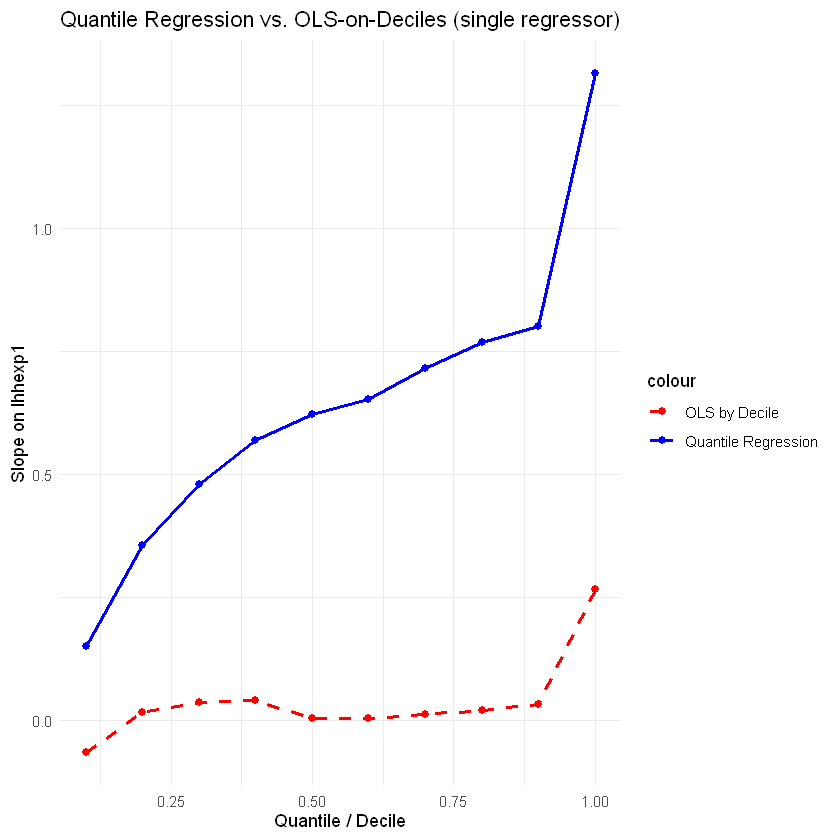

In [9]:
# data for single-regressor comparison
original_data <- q_data |> dplyr::select(lhhexp1, lhhex12m)

taus2 <- seq(0.1, 1, by = 0.1)

# QR slopes by quantile for model with intercept + lhhexp1
qr_betas <- sapply(taus2, function(tau) {
  coef(rq(lhhex12m ~ lhhexp1, data = original_data, tau = tau))
})
qr_betas <- t(qr_betas)
colnames(qr_betas) <- c("Intercept_qr", "Slope_qr")
qr_betas <- as.data.frame(qr_betas)
qr_betas$tau <- taus2

# OLS by decile of response
ols_data <- q_data |> dplyr::mutate(decile = dplyr::ntile(lhhex12m, 10))
ols_betas <- data.frame()
for (i in 1:10) {
  decile_data <- dplyr::filter(ols_data, decile == i)
  model <- lm(lhhex12m ~ lhhexp1, data = decile_data)
  coefs <- coef(model)
  ols_betas <- rbind(ols_betas,
                     data.frame(decile = i,
                                Intercept_ols = coefs[1],
                                Slope_ols = coefs[2]))
}

# Visual comparison
library(ggplot2)
comparison <- ggplot() +
  geom_line(data = qr_betas, aes(x = tau, y = Slope_qr, color = "Quantile Regression"), linewidth = 1.1) +
  geom_point(data = qr_betas, aes(x = tau, y = Slope_qr, color = "Quantile Regression"), size = 2) +
  geom_line(data = ols_betas, aes(x = decile/10, y = Slope_ols, color = "OLS by Decile"),
            linetype = "dashed", linewidth = 1) +
  geom_point(data = ols_betas, aes(x = decile/10, y = Slope_ols, color = "OLS by Decile"), size = 2) +
  labs(x = "Quantile / Decile", y = "Slope on lhhexp1",
       title = "Quantile Regression vs. OLS-on-Deciles (single regressor)") +
  scale_color_manual(values = c("Quantile Regression" = "blue", "OLS by Decile" = "red")) +
  theme_minimal()
comparison


 As can be seen from the graph plotting beta estimates from QR and OLS by deciles 
 returns significantly different results. The reason is that using OLS we splitted 
 the data into the deciles and performed 10 distinct estimating procedures. While,
 the quantile regression utilizes all the observations and weights them by the loss 
 function (considers conditional distributions of y given certain x). Therefore, 
 due to the absence of consideration of this dependence, the OLS estimates are 
 biased.

## Problem 3: MLE 
### 1) Generating Data Samples

We generated random samples from a chi-squared distribution with $k = 8$ degrees of freedom, using sample sizes $n = 5, 10, 20, 40, 100, 200, 500, 1000, 2000$.

For each sample, we computed descriptive statistics and plotted histograms with the theoretical chi-squared density

$$
f(x) = \frac{1}{2^{k/2}\Gamma(k/2)}x^{k/2 - 1}e^{-x/2}.
$$

The visual comparison shows that for small $n$, the empirical distributions are irregular and deviate from the theoretical chi-squared shape, while for large $n$, they become smoother and closely match the theoretical curve, illustrating the Law of Large Numbers.

We did use AI to optimize the code for the visual comparison.


  n_label     mean       sd       min       q1   median        q3      max
1     n=5 8.341436 5.191962 2.1055607 5.059959 7.492108 12.161641 14.88791
2    n=10 7.885401 3.598191 2.0288770 5.661100 8.495446 10.029937 12.68277
3    n=20 6.413251 2.612193 2.1114387 4.928903 6.321861  7.123200 12.24937
4    n=40 7.077079 3.366370 2.4044153 4.553400 6.908670  8.498360 17.35534
5   n=100 8.041959 3.900892 0.9707359 5.294277 7.307695  9.880059 20.80013
6   n=200 7.806679 3.794252 1.1501435 4.996562 7.374034 10.078777 24.68734
7   n=500 7.769699 3.812796 1.1720177 4.977334 7.265764  9.994590 24.82297
8  n=1000 7.944449 4.009040 0.9660254 5.019731 7.289491 10.110876 28.82998
9  n=2000 8.019619 3.969595 0.7425827 5.143894 7.367688 10.026316 35.05462


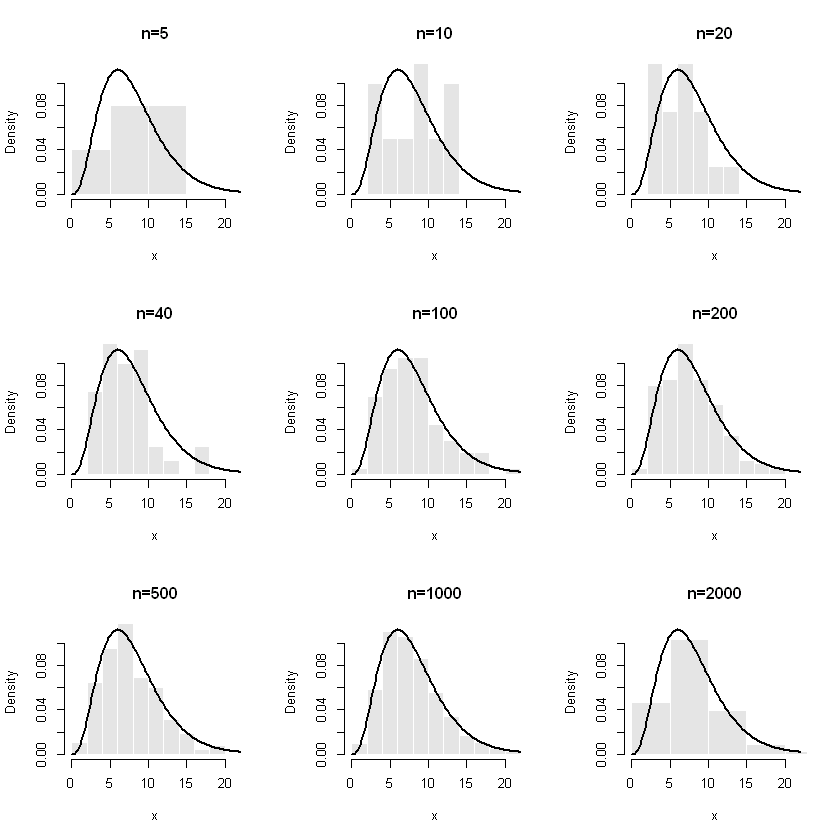

In [41]:
set.seed(123)

# Parameters
k <- 8  
ns <- c(5, 10, 20, 40, 100, 200, 500, 1000, 2000)

# Generate data
samples_list <- lapply(ns, function(n) rchisq(n, df = k))
names(samples_list) <- paste0("n=", ns)

# Descriptive statistics
desc_tbl <- do.call(rbind, lapply(names(samples_list), function(nm) {
v <- samples_list[[nm]]
qs <- quantile(v, probs = c(0, 0.25, 0.5, 0.75, 1))
data.frame(
n_label = nm,
mean = mean(v),
sd = sd(v),
min = qs[1],
q1 = qs[2],
median = qs[3],
q3 = qs[4],
max = qs[5]
)
}))
row.names(desc_tbl) <- NULL
print(desc_tbl)

# Visualization
x_max <- qchisq(0.995, df = k)
y_max <- max(dchisq(seq(0, x_max, length.out = 500), df = k))

par(mfrow = c(3, 3))
for (nm in names(samples_list)) {
  x <- samples_list[[nm]]
  hist(x, probability = TRUE, main = nm, xlab = "x",
       xlim = c(0, x_max), ylim = c(0, y_max), col = "grey90", border = "white")
  curve(dchisq(x, df = k), add = TRUE, lwd = 2)
}
par(mfrow = c(1, 1))

### 2) Estimating $k$ using MLE

For each generated sample, we estimated the parameter $k$ of the chi-squared distribution using the method of Maximum Likelihood.  
Assuming $X_i \sim \chi^2(k)$, the log-likelihood function is given by

$$
\ell(k) = -\frac{nk}{2}\ln(2) - n\ln\Gamma\left(\frac{k}{2}\right) + \left(\frac{k}{2}-1\right)\sum_{i=1}^n \ln x_i - \frac{1}{2}\sum_{i=1}^n x_i.
$$

Differentiating with respect to $k$ and setting the derivative to zero gives the likelihood equation

$$
\psi\left(\frac{k}{2}\right) = \overline{\ln X} - \ln(2),
$$

where $\psi(\cdot)$ is the digamma function.  
We solved this equation numerically using the Newton–Raphson algorithm and obtained $\hat{k}$ for each sample.  
The standard error of the estimator was computed as

$$
\mathrm{SE}(\hat{k}) = \sqrt{\frac{4}{n\,\psi_1(\hat{k}/2)}},
$$

where $\psi_1(\cdot)$ is the trigamma function.

The results show that as the sample size $n$ increases, the MLE $\hat{k}$ converges toward the true value $k = 8$, and its standard error decreases.  
The fitted chi-squared densities (dashed lines) increasingly align with the theoretical distribution (solid lines), and plotting the difference $f(x;\hat{k}) - f(x;k)$ confirms that deviations vanish with larger $n$, illustrating the MLE’s consistency for the whole distribution.  

Again, AI was used to optimize the code for visualization and plotting the difference between fitted and true densities.

  n_label    n    k_hat       se_k
1     n=5    5 7.767553 1.65114937
2    n=10   10 7.872920 1.17646878
3    n=20   20 6.848515 0.76836728
4    n=40   40 7.366534 0.56646334
5   n=100  100 8.086279 0.37768716
6   n=200  200 7.837620 0.26239911
7   n=500  500 7.832092 0.16588958
8  n=1000 1000 7.951690 0.11831017
9  n=2000 2000 8.065268 0.08432971


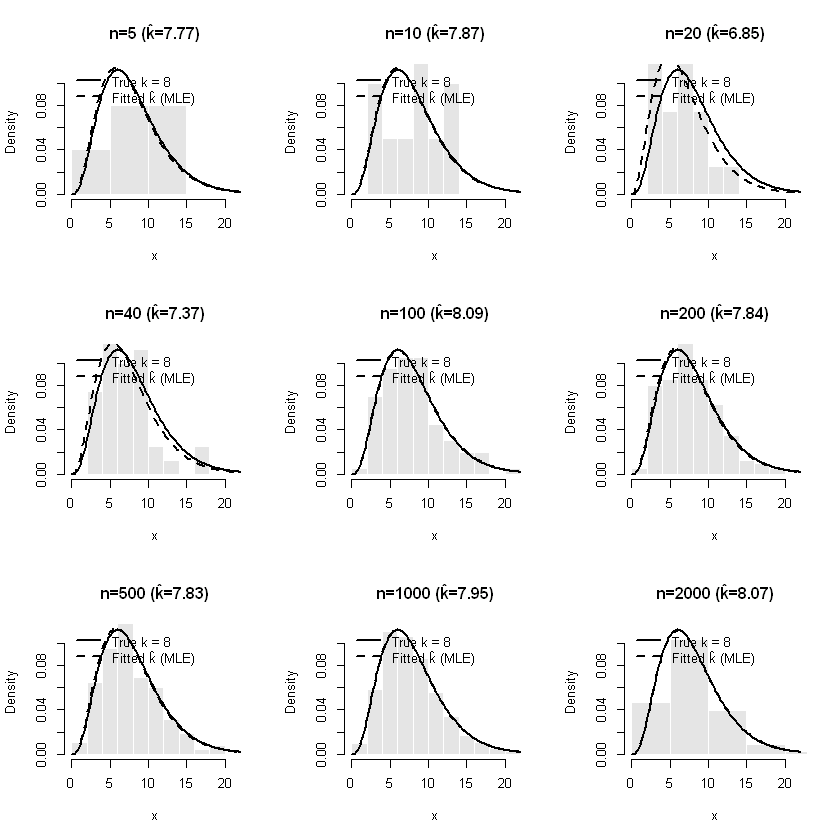

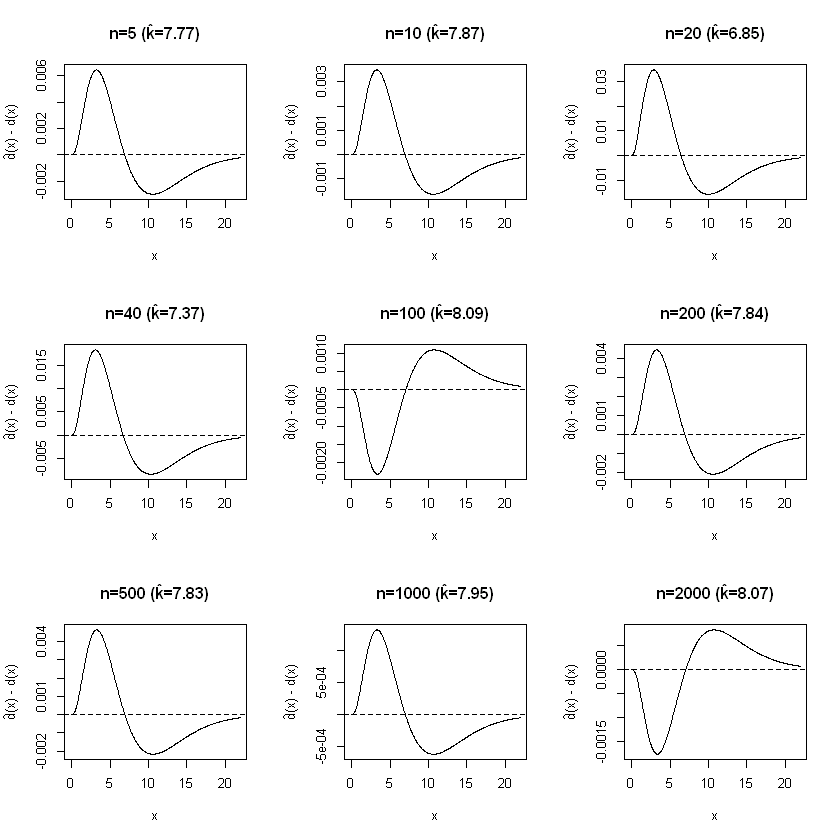

In [ ]:
# MLE function for k
mle_k <- function(x, tol = 1e-8, maxit = 50) {
  target <- mean(log(x)) - log(2)
  a <- 1
  for (i in 1:maxit) {
    g <- digamma(a) - target
    H <- psigamma(a, deriv = 1)
    a_new <- a - g / H
    if (abs(a_new - a) < tol) break
    a <- a_new
  }
  k_hat <- 2 * a
  se_k <- sqrt(4 / (length(x) * psigamma(a, deriv = 1)))
  c(k_hat = k_hat, se_k = se_k)
}

# Estimate k for each sample
mle_tbl <- do.call(rbind, lapply(names(samples_list), function(nm) {
  v <- samples_list[[nm]]
  est <- mle_k(v)
  data.frame(
    n_label = nm,
    n = length(v),
    k_hat = est["k_hat"],
    se_k = est["se_k"]
  )
}))
row.names(mle_tbl) <- NULL
print(mle_tbl)

# Visualization
x_max <- qchisq(0.995, df = k)
grid_x <- seq(0, x_max, length.out = 500)
y_max <- max(dchisq(grid_x, df = k))

par(mfrow = c(3, 3))
for (nm in names(samples_list)) {
  x <- samples_list[[nm]]
  k_hat <- mle_tbl$k_hat[mle_tbl$n_label == nm]

  hist(x,
       probability = TRUE, main = paste0(nm, " (k̂=", round(k_hat, 2), ")"),
       xlab = "x", col = "grey90", border = "white",
       xlim = c(0, x_max), ylim = c(0, y_max))

  curve(dchisq(x, df = k),      add = TRUE, lwd = 2)
  curve(dchisq(x, df = k_hat),  add = TRUE, lwd = 2, lty = 2)

  legend("topleft", bty = "n",
         legend = c(paste0("True k = ", k), "Fitted k̂ (MLE)"),
         lwd = 2, lty = c(1, 2))
}
par(mfrow = c(1, 1))

# Difference between fitted and true densities
x_max  <- qchisq(0.995, df=k)
grid_x <- seq(0, x_max, length.out=600)

par(mfrow = c(3, 3))
for (nm in names(samples_list)) {
  k_hat <- mle_tbl$k_hat[mle_tbl$n_label == nm]
  diffy <- dchisq(grid_x, df=k_hat) - dchisq(grid_x, df=k)
  plot(grid_x, diffy, type="l", xlab="x",
       ylab="d̂(x) - d(x)", main=paste0(nm," (k̂=",round(k_hat,2),")"))
  abline(h=0, lty=2)
}
par(mfrow = c(1, 1))

x_max  <- qchisq(0.995, df = k)
grid_x <- seq(0, x_max, length.out = 600)

### 3) Variance of the Estimator

The variance of the MLE, given by $\mathrm{Var}(\hat{k}) = \mathrm{SE}(\hat{k})^2$, was computed for each sample size.  
The plot shows that the variance decreases as $n$ increases, approximately following a $1/n$ pattern.  
This behavior reflects an essential property of MLE estimators — as the sample size grows, the estimator becomes more precise, and its variance approaches zero.  
This is consistent with the asymptotic efficiency of the MLE and the Law of Large Numbers.


  n_label    n    k_hat       se_k      var_k
1     n=5    5 7.767553 1.65114937 2.72629423
2    n=10   10 7.872920 1.17646878 1.38407879
3    n=20   20 6.848515 0.76836728 0.59038828
4    n=40   40 7.366534 0.56646334 0.32088071
5   n=100  100 8.086279 0.37768716 0.14264759
6   n=200  200 7.837620 0.26239911 0.06885329
7   n=500  500 7.832092 0.16588958 0.02751935
8  n=1000 1000 7.951690 0.11831017 0.01399730
9  n=2000 2000 8.065268 0.08432971 0.00711150


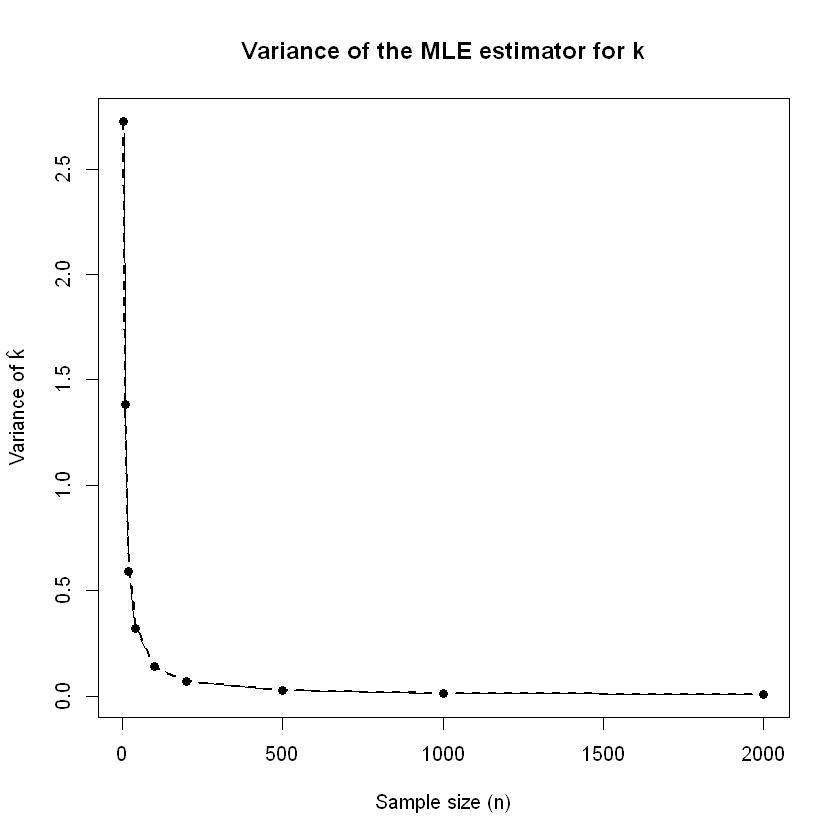

In [40]:
# Variance of the MLE for each sample size
mle_tbl$var_k <- mle_tbl$se_k^2

# Plot variance against sample size
plot(mle_tbl$n, mle_tbl$var_k, type = "b", pch = 16,
     xlab = "Sample size (n)", ylab = "Variance of k̂",
     main = "Variance of the MLE estimator for k")

# Reference line (decreasing with 1/n)
lines(mle_tbl$n, mle_tbl$var_k[1] * (mle_tbl$n[1] / mle_tbl$n), 
      lty = 2, lwd = 2)

# Table
print(mle_tbl[, c("n_label", "n", "k_hat", "se_k", "var_k")])

### 4) Fitting the Gamma Distribution using MLE

Using the sample with $n = 40$, we fitted a Gamma distribution of the form

$$
f(x) = \frac{1}{\Gamma(k)\theta^k}x^{k-1}e^{-x/\theta}
$$

by estimating both parameters $k$ (shape) and $\theta$ (scale) with the method of Maximum Likelihood.  
The estimation was carried out numerically using the `optim()` function, which maximizes the log-likelihood and provides the observed information matrix used to calculate standard errors.

The estimated parameters were $\hat{k} \approx 5.07$ and $\hat{\theta} \approx 1.39$, with corresponding standard errors around $1.10$ and $0.32$.  
These values imply that the fitted Gamma distribution has a mean of $\hat{k}\hat{\theta} \approx 7.07$, which is close to the theoretical mean of the $\chi^2(8)$ distribution ($E[X] = 8$).  
The estimated shape parameter is somewhat lower than the true value $k = 8$, which is expected given the relatively small sample size ($n = 40$) and the inherent sampling variability.

The standard errors suggest moderate uncertainty around the parameter estimates — larger than for bigger samples, but still reasonable for this sample size.  
Overall, the fitted Gamma distribution approximates the true underlying $\chi^2(8)$ shape fairly well, demonstrating that the MLE procedure can recover the parameters of the assumed distribution even with a limited number of observations.

In [ ]:
# Sample with n = 40
x <- samples_list[["n=40"]]
n <- length(x)

# Log-likelihood function for the Gamma(k, theta)
loglik_gamma <- function(params, x) {
  k <- params[1]
  theta <- params[2]
  if (k <= 0 || theta <= 0) return(-Inf)
  sum((k - 1) * log(x) - x / theta - k * log(theta) - lgamma(k))
}

# Maximize the log-likelihood
start_vals <- c(k = 1, theta = mean(x))  # simple starting values
fit <- optim(start_vals, loglik_gamma, x = x, control = list(fnscale = -1), hessian = TRUE)

# Extract estimates
k_hat <- fit$par[1]
theta_hat <- fit$par[2]

# Compute standard errors using the Hessian
se <- sqrt(diag(solve(-fit$hessian)))

# Compute fitted mean from the estimated parameters
fitted_mean <- k_hat * theta_hat

# Print results
cat("Estimated parameters (MLE):\n")
cat("k_hat     =", round(k_hat, 4), "   SE =", round(se[1], 4), "\n")
cat("theta_hat =", round(theta_hat, 4), "   SE =", round(se[2], 4), "\n")
cat("Fitted mean (k_hat * theta_hat) =", round(fitted_mean, 4), "\n")

Estimated parameters (MLE):
k_hat     = 5.0746    SE = 1.0988 
theta_hat = 1.3945    SE = 0.3174 
Fitted mean (k_hat * theta_hat) = 7.0767 


### 5) Testing the Chi-squared Assumption

We tested the null hypothesis $H_0: \theta = 2$ within the fitted Gamma model using the Likelihood Ratio, Wald, and Lagrange Multiplier tests. 
The value $\theta = 2$ is the scale parameter under which the Gamma distribution reduces to the chi-squared distribution ($\text{Gamma}(k/2,\, \theta = 2) = \chi^2_k$). 
All three tests produced $p$-values above common significance levels ($p_{LR} = 0.136$, $p_{Wald} = 0.056$, $p_{LM} = 0.633$), so we do not reject $H_0$. 
This suggests that the data can be adequately modeled by a chi-squared distribution.

To visualize the fit, we plotted a QQ-plot comparing the empirical quantiles of the sample with the theoretical quantiles of the restricted chi-squared model $\chi^2_{\text{df} = 2\hat{k}_0}$. 
The points closely follow the 45° reference line, indicating that the sample does not systematically deviate from the chi-squared shape. 
Overall, both the numerical tests and graphical evidence support the conclusion that the chi-squared model provides an adequate fit.


Likelihood-based tests for H0: theta = 2
LR test:   statistic = 2.218   p-value = 0.1364 
Wald test: statistic = 3.639   p-value = 0.0564 


LM test:statistic = 0.227   p-value = 0.6334 


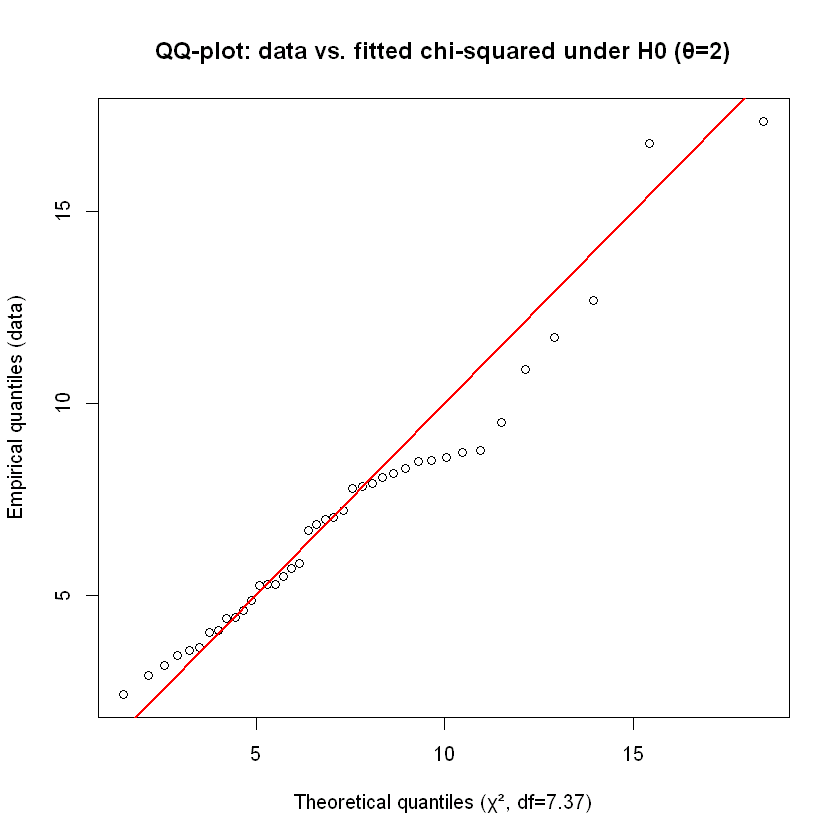

In [37]:
# H0
theta0 <- 2

# Restricted log-likelihood (fix theta = 2, estimate k only)
loglik_restricted <- function(k, x) {
  if (k <= 0) return(-Inf)
  sum((k - 1) * log(x) - x / theta0 - k * log(theta0) - lgamma(k))
}

# Optimize restricted log-likelihood for k
fit_restricted <- optimize(loglik_restricted, c(0.1, 50), x = x, maximum = TRUE)

# Log-likelihoods
ll_unrestricted <- fit$value
ll_restricted <- fit_restricted$objective

# Likelihood Ratio Test 
LR <- 2 * (ll_unrestricted - ll_restricted)
p_LR <- 1 - pchisq(LR, df = 1)

# Wald Test 
W <- (theta_hat - theta0)^2 / (se[2]^2)
p_Wald <- 1 - pchisq(W, df = 1)

# Lagrange Multiplier test
k0 <- fit_restricted$maximum
U_theta <- sum((x - k0 * theta0) / (theta0^2))
I_theta <- n * k0 / (theta0^2)
S <- (U_theta^2) / I_theta
p_Score <- 1 - pchisq(S, df = 1)

# Print results
cat("Likelihood-based tests for H0: theta = 2\n")
cat("LR test:   statistic =", round(LR, 3), "  p-value =", round(p_LR, 4), "\n")
cat("Wald test: statistic =", round(W, 3),  "  p-value =", round(p_Wald, 4), "\n")
cat("LM test:statistic =", round(S, 3),  "  p-value =", round(p_Score, 4), "\n")

# QQ-plot
df0 <- 2 * k0
qqplot(qchisq(ppoints(n), df = df0), x,
       main = "QQ-plot: data vs. fitted chi-squared under H0 (θ=2)",
       xlab = paste0("Theoretical quantiles (χ², df=", round(df0,2), ")"),
       ylab = "Empirical quantiles (data)")
abline(0, 1, col = "red", lwd = 2)
